In [1]:
import pandas as pd
import numpy as np  


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import sklearn


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import optuna

import xgboost as xgb


In [2]:
solar_train = pd.read_csv('../data/external/solar_train.csv')
solar_train.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475175023,9/29/2016 12:00:00 AM,08:50:23,634.99,61,30.46,41,14.96,6.75,06:13:00,18:13:00
1,1481799902,12/15/2016 12:00:00 AM,01:05:02,1.27,37,30.26,70,207.43,5.62,06:50:00,17:46:00
2,1478339417,11/4/2016 12:00:00 AM,23:50:17,1.21,47,30.49,33,168.20,5.62,06:25:00,17:47:00
3,1472887208,9/2/2016 12:00:00 AM,21:20:08,1.67,54,30.46,101,152.60,3.37,06:07:00,18:37:00
4,1478724901,11/9/2016 12:00:00 AM,10:55:01,839.78,62,30.47,36,291.95,7.87,06:28:00,17:45:00


In [10]:
sol_phys_train = pd.read_csv('../data/interim/solar_phys_train.csv')
sol_phys_train = sol_phys_train.drop('Unnamed: 0', axis=1)
sol_phys_train.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,634.99,289.26,4060.99,41,0.0416,3.02
1,1.27,275.93,4034.32,70,0.5762,2.51
2,1.21,281.48,4064.99,33,0.4672,2.51
3,1.67,285.37,4060.99,101,0.4239,1.51
4,839.78,289.82,4062.32,36,0.8110,3.52


In [22]:
sol_phys_train['Time'] =  pd.to_timedelta(solar_train['Time'])/ pd.to_timedelta(1, unit='D')

In [23]:
sol_phys_train.dtypes

Radiation                 float64
Temperature               float64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Time                      float64
dtype: object

In [24]:

X = sol_phys_train[[c for c in sol_phys_train if c != 'Radiation']].values
y = sol_phys_train[['Radiation']].values


In [25]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y,random_state=0, test_size=0.30)

In [26]:
def objective_xgb(trial):
# Invoke suggest methods of a Trial object to generate hyperparameters.

    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_val, label = y_val)

    param = {
        "silent": 1,
        "objective": 'reg:linear',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        'eval_metric': 'rmse'
    }

    if param["booster"] == "gbtree" or param["booster"] == "gblinear":
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000)        
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000) 
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    bst = xgb.train(param, dtrain)
    y_pred = bst.predict(dvalid)
 
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    
    
    return error # An objective value linked with the Trial object.

In [27]:
study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=300)
study_xgb.best_params

[I 2020-05-05 11:09:26,030] Finished trial#0 with value: 145993.65785736308 with parameters: {'booster': 'gbtree', 'lambda': 0.00019136854439573368, 'alpha': 4.031877354542622e-06, 'subsample': 0.012340592730098167, 'n_trees': 881, 'max_depth': 3, 'eta': 1.3997188524292385e-05, 'gamma': 0.039893582409128596, 'grow_policy': 'lossguide'}. Best is trial#0 with value: 145993.65785736308.
[I 2020-05-05 11:09:26,467] Finished trial#1 with value: 146020.90367835874 with parameters: {'booster': 'gblinear', 'lambda': 0.616901991407888, 'alpha': 3.5601961701862924e-07, 'subsample': 1.6513818797464496e-08, 'n_trees': 737, 'max_depth': 29, 'eta': 1.1042688855321316e-06, 'gamma': 0.00014985621997529367, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 145993.65785736308.
[I 2020-05-05 11:09:26,940] Finished trial#2 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 1.9629856398752215e-05, 'alpha': 0.28150005977306486, 'max_depth': 10, 'subsample': 3.752200828145464

[I 2020-05-05 11:09:37,436] Finished trial#20 with value: 146025.61239888644 with parameters: {'booster': 'gbtree', 'lambda': 0.00016944885799244797, 'alpha': 0.0013142699189027831, 'subsample': 0.00471672683738569, 'n_trees': 380, 'max_depth': 36, 'eta': 1.5428084060064368e-08, 'gamma': 0.03306545430498486, 'grow_policy': 'lossguide'}. Best is trial#15 with value: 11277.494679338492.
[I 2020-05-05 11:09:38,414] Finished trial#21 with value: 11473.669734776846 with parameters: {'booster': 'dart', 'lambda': 0.012329286251829162, 'alpha': 0.031074654587805374, 'max_depth': 62, 'subsample': 0.7612852938106066, 'n_trees': 999, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0496912949063338e-07, 'skip_drop': 7.962296298511124e-07}. Best is trial#15 with value: 11277.494679338492.
[I 2020-05-05 11:09:39,109] Finished trial#22 with value: 11947.385058375325 with parameters: {'booster': 'dart', 'lambda': 0.09601707287081275, 'alpha': 0.04246458902848722, 'max_depth': 64, 

[I 2020-05-05 11:09:51,021] Finished trial#39 with value: 94909.26873222078 with parameters: {'booster': 'gblinear', 'lambda': 0.035738962015337467, 'alpha': 1.0598368780133952e-07, 'subsample': 1.0886914776401036e-07, 'n_trees': 246, 'max_depth': 16, 'eta': 0.4781776167353391, 'gamma': 3.0328949815764607e-06, 'grow_policy': 'lossguide'}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:09:51,667] Finished trial#40 with value: 51790.21244142116 with parameters: {'booster': 'dart', 'lambda': 3.4078376293944946e-05, 'alpha': 6.945017747874329e-06, 'max_depth': 33, 'subsample': 0.00016278806609631283, 'n_trees': 328, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.0712952022533843e-07, 'skip_drop': 1.160466210625158e-08}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:09:53,364] Finished trial#41 with value: 12041.36099116502 with parameters: {'booster': 'dart', 'lambda': 6.235429572996488e-05, 'alpha': 5.6362950896360025e-05, 'max_

[I 2020-05-05 11:10:20,099] Finished trial#58 with value: 17601.605922192677 with parameters: {'booster': 'dart', 'lambda': 0.011911717809928082, 'alpha': 0.7075581486226175, 'max_depth': 59, 'subsample': 0.1639836581220448, 'n_trees': 945, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9784999826742708e-07, 'skip_drop': 4.5192089415702234e-06}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:10:20,685] Finished trial#59 with value: 121799.16151476924 with parameters: {'booster': 'dart', 'lambda': 5.678574617391299e-07, 'alpha': 6.810884679388637e-05, 'max_depth': 64, 'subsample': 3.989754306912674e-05, 'n_trees': 751, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1696703258235831e-08, 'skip_drop': 3.908370629078032e-05}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:10:21,179] Finished trial#60 with value: 26456.72803621585 with parameters: {'booster': 'dart', 'lambda': 0.05006622422939734, 'alpha': 2.609

[I 2020-05-05 11:10:34,880] Finished trial#77 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 0.03148313452084312, 'alpha': 0.010433986528309484, 'max_depth': 63, 'subsample': 1.3029802207253015e-06, 'n_trees': 942, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.62632592856802e-08, 'skip_drop': 9.248153162174922e-07}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:10:36,083] Finished trial#78 with value: 15040.379770345273 with parameters: {'booster': 'dart', 'lambda': 0.003465587387079662, 'alpha': 0.0006139973982624932, 'max_depth': 56, 'subsample': 0.9933458621601987, 'n_trees': 883, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.453788508980507e-08, 'skip_drop': 1.2851843248806e-07}. Best is trial#31 with value: 11203.257093118604.
[I 2020-05-05 11:10:36,759] Finished trial#79 with value: 20463.473924776245 with parameters: {'booster': 'dart', 'lambda': 0.000371355483205256, 'alpha': 0.08573

[I 2020-05-05 11:10:49,814] Finished trial#96 with value: 11668.691965435182 with parameters: {'booster': 'dart', 'lambda': 0.5393623211331988, 'alpha': 3.1566607231734577e-06, 'max_depth': 25, 'subsample': 0.6372099824271962, 'n_trees': 492, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.783923720815346e-08, 'skip_drop': 1.2346721543059291e-05}. Best is trial#92 with value: 11196.496635834928.
[I 2020-05-05 11:10:50,360] Finished trial#97 with value: 16413.69192279622 with parameters: {'booster': 'dart', 'lambda': 0.23681777705802423, 'alpha': 2.0895841064267298e-07, 'max_depth': 19, 'subsample': 0.1446626162747257, 'n_trees': 394, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8906748883116905e-07, 'skip_drop': 7.231126077037817e-07}. Best is trial#92 with value: 11196.496635834928.
[I 2020-05-05 11:10:50,761] Finished trial#98 with value: 142373.61659810663 with parameters: {'booster': 'gblinear', 'lambda': 0.12165837139056458, 'alpha': 6.

[I 2020-05-05 11:11:03,958] Finished trial#115 with value: 11325.861860899706 with parameters: {'booster': 'dart', 'lambda': 0.5804707486547823, 'alpha': 2.5945197761497716e-06, 'max_depth': 29, 'subsample': 0.9886695808099856, 'n_trees': 503, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.7744145403026095e-07, 'skip_drop': 3.0961995104169256e-05}. Best is trial#101 with value: 11001.389330984763.
[I 2020-05-05 11:11:04,801] Finished trial#116 with value: 12363.008907963707 with parameters: {'booster': 'dart', 'lambda': 0.982113377528728, 'alpha': 3.0463828538871274e-06, 'max_depth': 31, 'subsample': 0.34184015750550933, 'n_trees': 515, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1209589182751675e-06, 'skip_drop': 0.00010959121816211315}. Best is trial#101 with value: 11001.389330984763.
[I 2020-05-05 11:11:05,499] Finished trial#117 with value: 19638.77265373465 with parameters: {'booster': 'gbtree', 'lambda': 1.8757102597298015e-05, 'a

[I 2020-05-05 11:11:18,097] Finished trial#134 with value: 12385.548466437418 with parameters: {'booster': 'dart', 'lambda': 0.2758550092380377, 'alpha': 7.802567108365184e-07, 'max_depth': 29, 'subsample': 0.46454184623534245, 'n_trees': 460, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.291041932483207e-07, 'skip_drop': 0.10291191879978369}. Best is trial#127 with value: 10924.2632258216.
[I 2020-05-05 11:11:18,928] Finished trial#135 with value: 11224.812681027957 with parameters: {'booster': 'dart', 'lambda': 0.5813584985128923, 'alpha': 5.267955095003164e-06, 'max_depth': 21, 'subsample': 0.9088890283708881, 'n_trees': 666, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.719645440550352e-07, 'skip_drop': 0.40379464891685996}. Best is trial#127 with value: 10924.2632258216.
[I 2020-05-05 11:11:19,897] Finished trial#136 with value: 10770.917427795945 with parameters: {'booster': 'dart', 'lambda': 0.3361830071615933, 'alpha': 6.192852302

[I 2020-05-05 11:11:34,714] Finished trial#153 with value: 10751.468185613894 with parameters: {'booster': 'dart', 'lambda': 0.464261349104047, 'alpha': 3.2518180811316312e-06, 'max_depth': 12, 'subsample': 0.9924334499352241, 'n_trees': 629, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.248089982449441e-08, 'skip_drop': 0.04727720619964321}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:11:35,458] Finished trial#154 with value: 10996.82722300296 with parameters: {'booster': 'dart', 'lambda': 0.6811909170822151, 'alpha': 3.496324498498204e-06, 'max_depth': 12, 'subsample': 0.9860312610055538, 'n_trees': 725, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8417513174184305e-08, 'skip_drop': 0.06501516970153123}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:11:36,774] Finished trial#155 with value: 11798.433090404063 with parameters: {'booster': 'dart', 'lambda': 0.5877257800613681, 'alpha': 4.157758

[I 2020-05-05 11:11:55,609] Finished trial#172 with value: 11425.34175057584 with parameters: {'booster': 'dart', 'lambda': 0.7283873561792389, 'alpha': 1.2156458978849083e-05, 'max_depth': 12, 'subsample': 0.7051459608802054, 'n_trees': 687, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.415730476577243e-08, 'skip_drop': 0.973711930837999}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:11:56,313] Finished trial#173 with value: 10997.449276057661 with parameters: {'booster': 'dart', 'lambda': 0.7105840659262939, 'alpha': 3.258720051073088e-06, 'max_depth': 13, 'subsample': 0.9883980390334353, 'n_trees': 704, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00023391073597942325, 'skip_drop': 0.14954729561787838}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:11:56,938] Finished trial#174 with value: 11274.995779979237 with parameters: {'booster': 'dart', 'lambda': 0.45218715042090946, 'alpha': 1.924063

[I 2020-05-05 11:12:12,481] Finished trial#191 with value: 11208.106721010565 with parameters: {'booster': 'dart', 'lambda': 0.30201183637328644, 'alpha': 2.2360483915629344e-06, 'max_depth': 13, 'subsample': 0.9895879450861406, 'n_trees': 639, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.58806088120087e-05, 'skip_drop': 0.075640550562728}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:12:13,126] Finished trial#192 with value: 10779.932594435071 with parameters: {'booster': 'dart', 'lambda': 0.2551460091247303, 'alpha': 2.6964173654468085e-06, 'max_depth': 11, 'subsample': 0.9876082231729151, 'n_trees': 610, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00024631858883733505, 'skip_drop': 0.015708480949395105}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:12:13,788] Finished trial#193 with value: 11185.764688488562 with parameters: {'booster': 'dart', 'lambda': 0.07104700454959874, 'alpha': 3.488

[I 2020-05-05 11:12:24,028] Finished trial#210 with value: 13012.563933150186 with parameters: {'booster': 'dart', 'lambda': 0.2688125981609217, 'alpha': 5.971166811613183e-06, 'max_depth': 5, 'subsample': 0.40579535768371794, 'n_trees': 579, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013391935934018336, 'skip_drop': 0.010023679498775471}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:12:24,691] Finished trial#211 with value: 10906.103766560558 with parameters: {'booster': 'dart', 'lambda': 0.34209924998913727, 'alpha': 7.819384440379456e-07, 'max_depth': 10, 'subsample': 0.9982535712706853, 'n_trees': 623, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.024606501453493516, 'skip_drop': 0.0063989445951234845}. Best is trial#153 with value: 10751.468185613894.
[I 2020-05-05 11:12:25,566] Finished trial#212 with value: 10879.73376601869 with parameters: {'booster': 'dart', 'lambda': 0.32105502569342365, 'alpha': 7.8560

[I 2020-05-05 11:12:36,363] Finished trial#229 with value: 118488.2495699034 with parameters: {'booster': 'dart', 'lambda': 0.1714863635046702, 'alpha': 1.015576875849329e-06, 'max_depth': 9, 'subsample': 3.824092898112201e-05, 'n_trees': 732, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0015761831770025464, 'skip_drop': 0.020530566683423256}. Best is trial#216 with value: 10656.5920114038.
[I 2020-05-05 11:12:36,853] Finished trial#230 with value: 95598.97503866155 with parameters: {'booster': 'gblinear', 'lambda': 0.4414337717804452, 'alpha': 1.1968862133464294e-05, 'subsample': 0.9929669654513603, 'n_trees': 702, 'max_depth': 11, 'eta': 0.8863353234624288, 'gamma': 0.006645475954821922, 'grow_policy': 'lossguide'}. Best is trial#216 with value: 10656.5920114038.
[I 2020-05-05 11:12:37,530] Finished trial#231 with value: 10590.043845907021 with parameters: {'booster': 'dart', 'lambda': 0.35295891254603273, 'alpha': 6.594318312457166e-07, 'max_depth': 12, 'sub

[I 2020-05-05 11:12:48,022] Finished trial#248 with value: 12176.53370000914 with parameters: {'booster': 'dart', 'lambda': 0.27204505225621733, 'alpha': 5.96332753932183e-07, 'max_depth': 11, 'subsample': 0.3673355784142847, 'n_trees': 579, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0005531045231357582, 'skip_drop': 0.018008021143721516}. Best is trial#231 with value: 10590.043845907021.
[I 2020-05-05 11:12:48,655] Finished trial#249 with value: 11054.258381600213 with parameters: {'booster': 'dart', 'lambda': 0.4628426912438429, 'alpha': 2.7637151591784196e-07, 'max_depth': 8, 'subsample': 0.981299249525636, 'n_trees': 601, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.029937898052639335, 'skip_drop': 0.03093083950852796}. Best is trial#231 with value: 10590.043845907021.
[I 2020-05-05 11:12:49,291] Finished trial#250 with value: 10947.13281924407 with parameters: {'booster': 'dart', 'lambda': 0.22276804304858752, 'alpha': 9.38468176

[I 2020-05-05 11:12:59,193] Finished trial#267 with value: 11507.16916002305 with parameters: {'booster': 'dart', 'lambda': 0.32016376797730306, 'alpha': 4.902192190628295e-07, 'max_depth': 8, 'subsample': 0.6912951993644313, 'n_trees': 555, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.002545096148654741, 'skip_drop': 0.005161604416018244}. Best is trial#231 with value: 10590.043845907021.
[I 2020-05-05 11:12:59,788] Finished trial#268 with value: 10892.235801297204 with parameters: {'booster': 'dart', 'lambda': 0.12361421880446187, 'alpha': 6.83989347111818e-07, 'max_depth': 10, 'subsample': 0.7143773367177269, 'n_trees': 602, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006220448959851839, 'skip_drop': 0.029068358022752715}. Best is trial#231 with value: 10590.043845907021.
[I 2020-05-05 11:13:00,422] Finished trial#269 with value: 11065.925851303738 with parameters: {'booster': 'dart', 'lambda': 0.0739914350184175, 'alpha': 7.029532

[I 2020-05-05 11:13:11,099] Finished trial#286 with value: 12611.5877541003 with parameters: {'booster': 'dart', 'lambda': 0.4940586105803947, 'alpha': 5.53561407370651e-05, 'max_depth': 12, 'subsample': 0.3345903175920806, 'n_trees': 601, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010348923986312276, 'skip_drop': 0.025419003910863346}. Best is trial#274 with value: 10472.270336991147.
[I 2020-05-05 11:13:11,700] Finished trial#287 with value: 17182.258727083332 with parameters: {'booster': 'dart', 'lambda': 0.1490152652926923, 'alpha': 4.866497472709733e-06, 'max_depth': 10, 'subsample': 0.9902268024317765, 'n_trees': 633, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19479669110018633, 'skip_drop': 0.013750543445565293}. Best is trial#274 with value: 10472.270336991147.
[I 2020-05-05 11:13:12,430] Finished trial#288 with value: 11958.262133766018 with parameters: {'booster': 'dart', 'lambda': 0.35893158737756026, 'alpha': 1.55791881

{'booster': 'dart',
 'lambda': 0.5157856762154167,
 'alpha': 1.7607880241744528e-05,
 'max_depth': 12,
 'subsample': 0.7449628996074313,
 'n_trees': 561,
 'sample_type': 'weighted',
 'normalize_type': 'forest',
 'rate_drop': 0.0009489262805187059,
 'skip_drop': 0.021213526897038672}

In [31]:
xgb_params = study_xgb.best_params
xgb_params

{'booster': 'dart',
 'lambda': 0.5157856762154167,
 'alpha': 1.7607880241744528e-05,
 'max_depth': 12,
 'subsample': 0.7449628996074313,
 'n_trees': 561,
 'sample_type': 'weighted',
 'normalize_type': 'forest',
 'rate_drop': 0.0009489262805187059,
 'skip_drop': 0.021213526897038672}

In [29]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_val)

In [57]:
cv_output

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,272.252869,1.883299,276.437887,3.434756
1,200.100214,1.625676,209.167089,3.541148
2,149.790573,1.346448,164.964228,3.430791
3,115.380341,1.213709,137.335393,3.573058
4,91.838832,1.270224,121.722064,2.961723
5,75.516355,1.353336,112.549718,2.488158
6,63.989957,1.597253,107.964727,2.489647
7,55.919578,1.733534,105.529302,2.222928
8,49.797945,1.358653,104.303157,2.419213
9,44.791522,0.942054,103.609146,2.342131


[0]	train-rmse:272.253	test-rmse:276.438


<Figure size 1080x720 with 0 Axes>

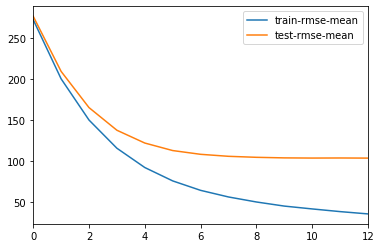

In [59]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=200, show_stdv=False)

plt.figure(figsize=(15,10))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [33]:
num_boost_rounds = len(cv_output)
print(num_boost_rounds)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

13


In [34]:
sol_phys_test = pd.read_csv('../data/interim/solar_phys_test.csv')
sol_phys_test = sol_phys_test.drop('Unnamed: 0', axis=1)
sol_phys_test.head()

,id,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,0,288.15,4062.32,44,0.8685,1.51
1,1,288.15,4063.65,83,0.1056,3.02
2,2,281.48,4051.66,78,0.5934,2.51
3,3,280.37,4052.99,98,0.4906,2.01
4,4,280.37,4052.99,34,0.4886,3.02


In [38]:
solar_original_test = pd.read_csv('../data/external/solar_test.csv')
solar_original_test.head()

,id,UNIXTime,Data,Time,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,0,1478720107,11/9/2016 12:00:00 AM,09:35:07,59,30.47,44,312.67,3.37,06:28:00,17:45:00
1,1,1474063503,9/16/2016 12:00:00 AM,12:05:03,59,30.48,83,38.01,6.75,06:10:00,18:25:00
2,2,1476109221,10/10/2016 12:00:00 AM,04:20:21,47,30.39,78,213.62,5.62,06:16:00,18:03:00
3,3,1481475056,12/11/2016 12:00:00 AM,06:50:56,45,30.40,98,176.63,4.50,06:47:00,17:44:00
4,4,1477493117,10/26/2016 12:00:00 AM,04:45:17,45,30.40,34,175.89,6.75,06:21:00,17:52:00


In [39]:
sol_phys_test['Time'] =  pd.to_timedelta(solar_original_test['Time'])/ pd.to_timedelta(1, unit='D')

In [40]:
X_t = sol_phys_test.drop('id',axis=1)

In [47]:
X_t.values

array([[2.88150000e+02, 4.06232000e+03, 4.40000000e+01, 8.68500000e-01,
        1.51000000e+00, 3.99386574e-01],
       [2.88150000e+02, 4.06365000e+03, 8.30000000e+01, 1.05600000e-01,
        3.02000000e+00, 5.03506944e-01],
       [2.81480000e+02, 4.05166000e+03, 7.80000000e+01, 5.93400000e-01,
        2.51000000e+00, 1.80798611e-01],
       ...,
       [2.82590000e+02, 4.06099000e+03, 4.30000000e+01, 4.32500000e-01,
        5.53000000e+00, 2.71099537e-01],
       [2.81480000e+02, 4.06232000e+03, 3.90000000e+01, 4.33900000e-01,
        5.53000000e+00, 9.23842593e-01],
       [2.91480000e+02, 4.06499000e+03, 2.40000000e+01, 6.14000000e-02,
        3.52000000e+00, 4.58414352e-01]])

In [49]:
dvalidation = xgb.DMatrix(X_t.values)
predic_testf = model.predict(dvalidation)
submission6 = pd.DataFrame()
submission6['id'] = sol_phys_test['id']
submission6['Radiation'] = predic_testf

In [53]:
submission6[submission6['Radiation']<0].shape

(33, 2)

In [54]:
submission6['Radiation'] = submission6['Radiation'].apply(lambda x: x if x >= 0 else 0)
submission6.describe()

,id,Radiation
count,8172.000000,8172.000000
mean,4085.500000,201.872564
std,2359.197533,299.142023
min,0.000000,0.000000
25%,2042.750000,1.318218
50%,4085.500000,2.539305
75%,6128.250000,369.007050
max,8171.000000,1083.679688


In [55]:
submission6.to_csv('../data/processed/submission6.csv')